In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random

import glob

from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(6, 4)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

def plot_RFC_prob_vs_lc(dataframe, anom_thresh):
    import antares_client

    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/"
    anom_thresh = anom_thresh

    num_anom_epochs_l = []
    anom_ztfid_l, tnscls_l = [],[]
    for anom_ztfid, tnscls in zip(dataframe.index, dataframe.tns_cls):
        print(anom_ztfid, tnscls)
        try:
            lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        except:
            print(f"couldn't feature space as func of time for {anom_ztfid}. Make anom epoch -9")
            num_anom_epochs_l.append(-9)
            continue

        lc_and_hosts_df = lc_and_hosts_df.dropna()
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]

        
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
            num_anom_epochs_l.append(num_anom_epochs)
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            continue

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            #if len(np.where(pred_prob_anom[:, 1]>=anom_thresh)) == 1:
            if not np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0] == 0:
                anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            else: anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx_is = True

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False

        ztf_id_ref = anom_ztfid 

        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

        try: df_ref = ref_info.timeseries.to_pandas()
        except: 
            print(f"No ref_info.timeseries.to_pandas() for {anom_ztfid}. Continue...")
            continue

        print(num_anom_epochs)
        anom_ztfid_l.append(anom_ztfid), tnscls_l.append(tnscls)

        df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
        df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
        ax1.invert_yaxis()
        ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        #ax1.axvline(x=lc_and_hosts_df.loc[lc_and_hosts_df.loc[anom_idx].obs_num].mjd_cutoff)
        if anom_idx_is == True:
            ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))
        ax1.set_ylabel('Mag')


        print(f'https://alerce.online/object/{anom_ztfid}', tnscls)
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
        #ax2.axhline(y=50)

        ax2.set_ylabel('Probability (%)')


        #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

        plt.xlabel('mjd_cutoff')
        plt.legend()
        plt.show()
        
def plot_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path):
    # Predict Excluded Object
    import antares_client
    
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        pass

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    anom_obj_df = lc_and_hosts_df[lc_and_host_features]

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
        orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        diff = len(orig)-len(pred_prob_anom)
        anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
        anom_idx_is = True

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False
    
    ztf_id_ref = anom_ztfid 

    ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                label=f'REF: {ztf_id_ref}')
    ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
    if anom_idx_is == True:
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        print("MJD crossed thresh:", lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
    #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    print(f'https://alerce.online/object/{anom_ztfid}')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
    print("Max anom score:", print(max(pred_prob_anom[:, 1])))
    #ax2.axhline(y=50)

    #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    plt.xlabel('mjd_cutoff')
    plt.ylabel('Probability (%)')
    plt.legend()
    plt.show()
    
def save_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path, clf, full_timeseries=True):
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        return

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    
    try:
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]
    except:
        print(f"{anom_ztfid} has some NaN LC features. Skip!")
        return

    if full_timeseries: #default, full timeseries
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            return

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx_is = True
            print("Anomalous during timeseries!")

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False
            
    if not full_timeseries: # full LC ONLY
        anom_obj_df = pd.DataFrame(anom_obj_df.iloc[-1]).T # last row of df to test "full LC only"
            
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            return

        if num_anom_epochs == 1: 
            anom_idx_is = True
            print("Anomalous at end of full LC!")
        else:
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False
        
    if anom_idx_is == True:
        anom_idx_is = "Other"
    elif anom_idx_is == False:
        anom_idx_is = "Normal"
    else: 
        anom_idx_is = "???"
        
    return anom_ztfid, anom_idx_is

In [200]:
def plot_RFC_prob_vs_lc(dataframe, anom_thresh):
    import antares_client

    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/"
    anom_thresh = anom_thresh

    num_anom_epochs_l = []
    anom_ztfid_l, tnscls_l = [],[]
    for anom_ztfid, tnscls in zip(dataframe.index, dataframe.tns_cls):
        print(anom_ztfid, tnscls)
        try:
            lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        except:
            print(f"couldn't feature space as func of time for {anom_ztfid}. Make anom epoch -9")
            num_anom_epochs_l.append(-9)
            continue

        lc_and_hosts_df = lc_and_hosts_df.dropna()
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]

        
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
            pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
            num_anom_epochs_l.append(num_anom_epochs)
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            continue

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            #if len(np.where(pred_prob_anom[:, 1]>=anom_thresh)) == 1:
            if not np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0] == 0:
                anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            else: anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx_is = True

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False

        ztf_id_ref = anom_ztfid 

        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

        try: df_ref = ref_info.timeseries.to_pandas()
        except: 
            print(f"No ref_info.timeseries.to_pandas() for {anom_ztfid}. Continue...")
            continue

        print(num_anom_epochs)
        anom_ztfid_l.append(anom_ztfid), tnscls_l.append(tnscls)

        df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
        df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
        ax1.invert_yaxis()
        ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        #ax1.axvline(x=lc_and_hosts_df.loc[lc_and_hosts_df.loc[anom_idx].obs_num].mjd_cutoff)
        if anom_idx_is == True:
            ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))
        ax1.set_ylabel('Mag')


        print(f'https://alerce.online/object/{anom_ztfid}', tnscls)
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
        #ax2.axhline(y=50)

        ax2.set_ylabel('Probability (%)')


        #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

        plt.xlabel('mjd_cutoff')
        plt.legend()
        plt.show()
        
def plot_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path):
    # Predict Excluded Object
    import antares_client
    
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        pass

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    anom_obj_df = lc_and_hosts_df[lc_and_host_features]

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
        pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
        max_anom_score = max(pred_prob_anom[:, 1])
        print("max_anom_score", max_anom_score)
        print("num_anom_epochs", num_anom_epochs)
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
        orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        diff = len(orig)-len(pred_prob_anom)
        anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num #+ diff
        anom_idx_is = True

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False
    
    ztf_id_ref = anom_ztfid 

    ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                label=f'REF: {ztf_id_ref}')
    ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
    if anom_idx_is == True:
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        print("MJD crossed thresh:", lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
    #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    print(f'https://alerce.online/object/{anom_ztfid}')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
    #ax2.axhline(y=50)
    #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    plt.xlabel('mjd_cutoff')
    plt.ylabel('Probability (%)')
    plt.legend()
    plt.show()
    
def save_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path, clf, full_timeseries=True):
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        return

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    
    try:
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]
    except:
        print(f"{anom_ztfid} has some NaN LC features. Skip!")
        return

    if full_timeseries: #default, full timeseries
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
            pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
            max_anom_score = max(pred_prob_anom[:, 1])
            print("max_anom_score", max_anom_score)
            print("num_anom_epochs", num_anom_epochs)
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            return

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            #anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num #+ diff
            anom_idx_is = True
            print("Anomalous during timeseries!")

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False
            
            
    if not full_timeseries: # full LC ONLY
        anom_obj_df = pd.DataFrame(anom_obj_df.iloc[-1]).T # last row of df to test "full LC only"
            
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
            pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
            max_anom_score = max(pred_prob_anom[:, 1])
            print("max_anom_score", max_anom_score)
            print("num_anom_epochs", num_anom_epochs)
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            return

        if num_anom_epochs == 1: 
            anom_idx_is = True
            print("Anomalous at end of full LC!")
        else:
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False
        
    if anom_idx_is == True:
        anom_idx_is = "Other"
    elif anom_idx_is == False:
        anom_idx_is = "Normal"
    else: 
        anom_idx_is = "???"
        
    return anom_ztfid, anom_idx_is

In [5]:
n_estimators=100 #3500
max_depth=35 #35
random_state=11
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
#class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
#       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"
class_weight={"Normal": 1, "Other": 1} #"balanced"

figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/model"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

cm_path = f"{figure_path}/confusion_matrix/"
if not os.path.exists(cm_path):
    os.makedirs(cm_path)

In [6]:
with open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
    clf = pickle.load(f)

In [7]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import light_curve as lc
from itertools import chain
import light_curve as lc
from astropy.table import MaskedColumn

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client


def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

In [8]:
import astro_ghost
# from astro_ghost.PS1QueryFunctions import getAllPostageStamps
# from astro_ghost.TNSQueryFunctions import getTNSSpectra
# from astro_ghost.NEDQueryFunctions import getNEDSpectra
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime
import tempfile

# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
getGHOST(real=True,verbose=False)

GHOST database already exists in the install path!


In [9]:
astro_ghost.__version__

'2.0.16'

In [10]:
def extract_lc_and_host_features(ztf_id_ref, spec_class, show_lc=False, show_host=False):
    ztf_id_ref = ztf_id_ref #'ZTF20aalxlis' #'ZTF21abmspzt'
    spec_class = spec_class
    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries"

    try:
        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
        df_ref = ref_info.timeseries.to_pandas()
    except:
        print("antares_client can't find this object. Skip! Continue...")
        return
    
    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    try:
        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag
    except:
        print(f"No obs for {ztf_id_ref}. pass!\n")
        return
    
    if show_lc:
        fig, ax = plt.subplots(figsize=(7,7))
        plt.gca().invert_yaxis()

        ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        plt.show()
        
    min_obs_count=4

    lightcurve = ref_info.lightcurve
    feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)


    g_obs = list(get_detections(lightcurve, 'g').ant_mjd.values)
    r_obs = list(get_detections(lightcurve, 'R').ant_mjd.values)
    mjd_l = sorted(g_obs+r_obs)

    lc_properties_d_l = []
    len_det_counter_r,len_det_counter_g = 0,0

    band_lc = lightcurve[(~lightcurve['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    all_detections = remove_simultaneous_alerts(band_lc[idx])
    for ob, mjd in enumerate(mjd_l): # requires 4 obs
        # do time evolution of detections - in chunks

        detections_pb = all_detections[all_detections['ant_mjd'].values <= mjd]
        #print(detections)
        lc_properties_d={}
        for band, names in property_names.items():
            detections = detections_pb[detections_pb['ant_passband'] == band]

            # Ensure locus has >3 obs for calculation
            if (len(detections) < min_obs_count):
                continue
            #print(detections)

            t = detections['ant_mjd'].values
            m = detections['ant_mag'].values
            merr = detections['ant_magerr'].values
            flux = np.power(10.0, -0.4 * m)
            fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

            magn_features = MAGN_EXTRACTOR(
                t,
                m,
                merr,
                fill_value=None,
            )
            flux_features = FLUX_EXTRACTOR(
                t,
                flux,
                fluxerr,
                fill_value=None,
            )

            # After successfully calculating features, set locus properties and tag
            lc_properties_d["obs_num"] = int(ob)
            lc_properties_d["mjd_cutoff"] = mjd
            lc_properties_d["ztf_object_id"] = ztf_id_ref
            #print(band, m)
            for name, value in zip(names, chain(magn_features, flux_features)):
                lc_properties_d[name] = value
                #if name == "feature_amplitude_magn_g": print(m, value, band)
            #print("%%%%%%%%")
        lc_properties_d_l.append(lc_properties_d)

    lc_properties_d_l = [d for d in lc_properties_d_l if d]
    lc_properties_df = pd.DataFrame(lc_properties_d_l)
    if len(lc_properties_df) == 0: 
        print(f"Not enough obs for {ztf_id_ref}. pass!\n")
        return
    print(f"Extracted LC features for {ztf_id_ref}!")
    
    # Get GHOST features
    ra,dec=np.mean(df_ref.ant_ra),np.mean(df_ref.ant_dec)
    snName=[ztf_id_ref, ztf_id_ref]
    snCoord = [SkyCoord(ra*u.deg, dec*u.deg, frame='icrs'), SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')]
    with tempfile.TemporaryDirectory() as tmp:
        try:
            hosts = getTransientHosts(transientName=snName, snCoord=snCoord, GLADE=True, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)
        except:
            print(f"GHOST error for {ztf_id_ref}. Retry without GLADE. \n")
            hosts = getTransientHosts(transientName=snName, snCoord=snCoord, GLADE=False, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)       
            
    if len(hosts) > 1:
        hosts = pd.DataFrame(hosts.loc[0]).T
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = hosts_df[~hosts_df.isnull().any(axis=1)]

    if len(hosts_df) < 1:
        # if any features are nan, we can't use as input
        print(f"Some features are NaN for {ztf_id_ref}. Skip!\n")
        return
        
    if show_host:
        print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts.raMean.values[0]}+{hosts.decMean.values[0]}&filter=color')
    
    # Define the label array
    label_arr = np.array(['ILRT', 'SLSN-I', 'SLSN-II', 'SN', 'SN II', 'SN II-pec', 'SN IIP',
       'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like',
       'SN Ia-CSM', 'SN Ia-Ca-rich', 'SN Ia-pec', 'SN Iax[02cx-like]',
       'SN Ib', 'SN Ib-Ca-rich', 'SN Ib/c', 'SN Ibn', 'SN Ic', 'SN Ic-BL',
       'SN Icn', 'TDE', 'AGN'])

    # Define the spectroscopic class
    spec_class = spec_class

    # Find the index of the spectroscopic class in the label array
    class_index = np.where(label_arr == spec_class)[0]

    # Create a one-hot encoded array with all zeros
    onehot_array = np.zeros(len(label_arr), dtype=float)

    # Set the corresponding index to 1
    onehot_array[class_index] = 1

    # Reshape the array to have a shape of (1, num_classes)
    onehot_array = onehot_array.reshape(1, -1)
    
    onehot_df = pd.DataFrame(np.array(onehot_array, dtype=float), columns=label_arr)
    onehot_df = pd.concat([onehot_df] * len(lc_properties_df), ignore_index=True)
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = pd.concat([hosts_df] * len(lc_properties_df), ignore_index=True)

    lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df, onehot_df], axis=1)
    lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
    lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}_timeseries.csv')
    
    print(f"Saved results for {ztf_id_ref}!\n")

In [184]:
ztfid_onsky_l = ["ZTF23aatabje"] 
spec_cls_onsky_l = ["SN Ia-CSM"]

onsky_df = pd.DataFrame(zip(ztfid_onsky_l, spec_cls_onsky_l), columns=["Disc. Internal Name", "TNS_cls"])
onsky_df = onsky_df.set_index("Disc. Internal Name")
onsky_df

,TNS_cls
Disc. Internal Name,
ZTF23aatabje,SN Ia-CSM


In [188]:
%%time

for i, (ztf_obj_test, spec_cls) in enumerate(zip(onsky_df.index, onsky_df.TNS_cls)):
    
    if i % 50 == 0: print(i)
    
    if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztf_obj_test}_timeseries.csv"): 
        print(f'{ztf_obj_test} is already made. Continue!\n')
        continue
    
    else:
        extract_lc_and_host_features(ztf_id_ref=ztf_obj_test, spec_class=spec_cls, show_lc=False, show_host=True)

0
Extracted LC features for ZTF23aatabje!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=259.20279964+47.9196414&filter=color
Saved results for ZTF23aatabje!

CPU times: user 4.13 s, sys: 300 ms, total: 4.43 s
Wall time: 6.79 s


ZTF23aatabje
max_anom_score 55.9
num_anom_epochs 2


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


MJD crossed thresh: 60184.18209489994
https://alerce.online/object/ZTF23aatabje


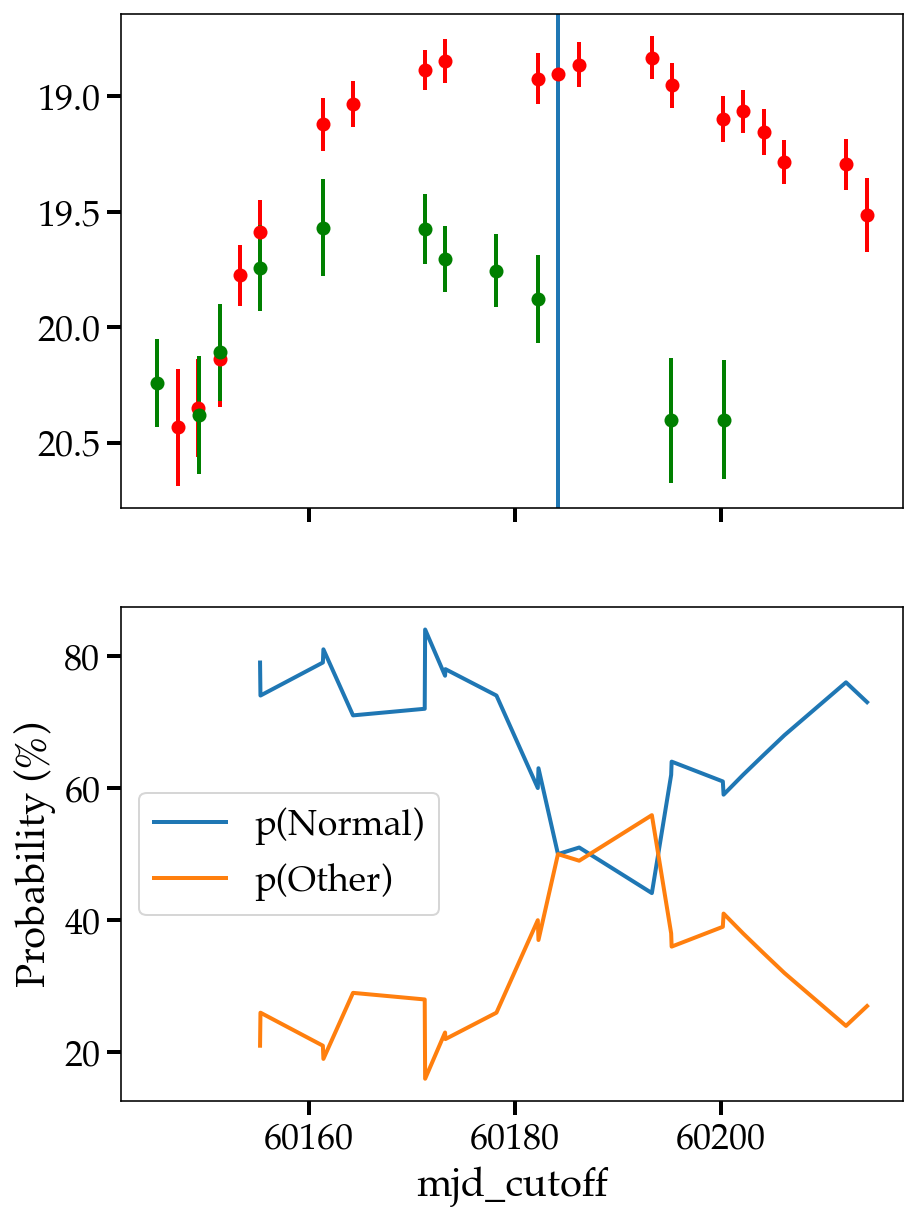

CPU times: user 649 ms, sys: 65.7 ms, total: 714 ms
Wall time: 636 ms


In [201]:
%%time

fps = glob.glob("/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/*")

for fp in fps:
    ztfid = fp.split('/')[-1].split('_')[0]
    
    for obj in onsky_df.index:
        if ztfid == obj:
            try:
                print(ztfid)
                plot_RFC_prob_vs_lc_ztfid(anom_ztfid=ztfid, 
                                          anom_thresh=50, 
                                          df_path=f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/",)
            except:
                continue

In [202]:
def plot_RFC_prob_vs_lc_ztfid_gemini_prop(anom_ztfid, anom_thresh, df_path, spec_tag_MJD, title, savefig=False):
    # Predict Excluded Object
    import antares_client
    
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        pass

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    anom_obj_df = lc_and_hosts_df[lc_and_host_features]

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
        pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
        max_anom_score = max(pred_prob_anom[:, 1])
        print("max_anom_score", max_anom_score)
        print("num_anom_epochs", num_anom_epochs)
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
        orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        diff = len(orig)-len(pred_prob_anom)
        anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num #+ diff
        anom_idx_is = True

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False
    
    ztf_id_ref = anom_ztfid 

    ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, ax = plt.subplots(figsize=(8,5))
    ax.invert_yaxis()
    ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', )
    ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g', )
    if anom_idx_is == True:
        ax.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0],
                  label="Tagged anomalous", color='darkblue', ls='--')
        print("MJD crossed thresh:", lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        ax.axvline(x=spec_tag_MJD, label="Gemini follow-up", color='orange', ls='--')
        ax.axvspan(lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0], 
                   spec_tag_MJD, alpha=0.2, color='gray')
        plt.text(0.21, 0.15, fr'{round(spec_tag_MJD - lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0], 1)} days', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=14)
    #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    print(f'https://alerce.online/object/{anom_ztfid}')

    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.title(f'{title}')
    plt.legend(frameon=False,
           loc='upper right')
    if savefig:
        plt.savefig(f"./Gemini_proposal/{anom_ztfid}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

ZTF22aafrjnw
max_anom_score 50.0
num_anom_epochs 3


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


MJD crossed thresh: 59690.283321800176
https://alerce.online/object/ZTF22aafrjnw


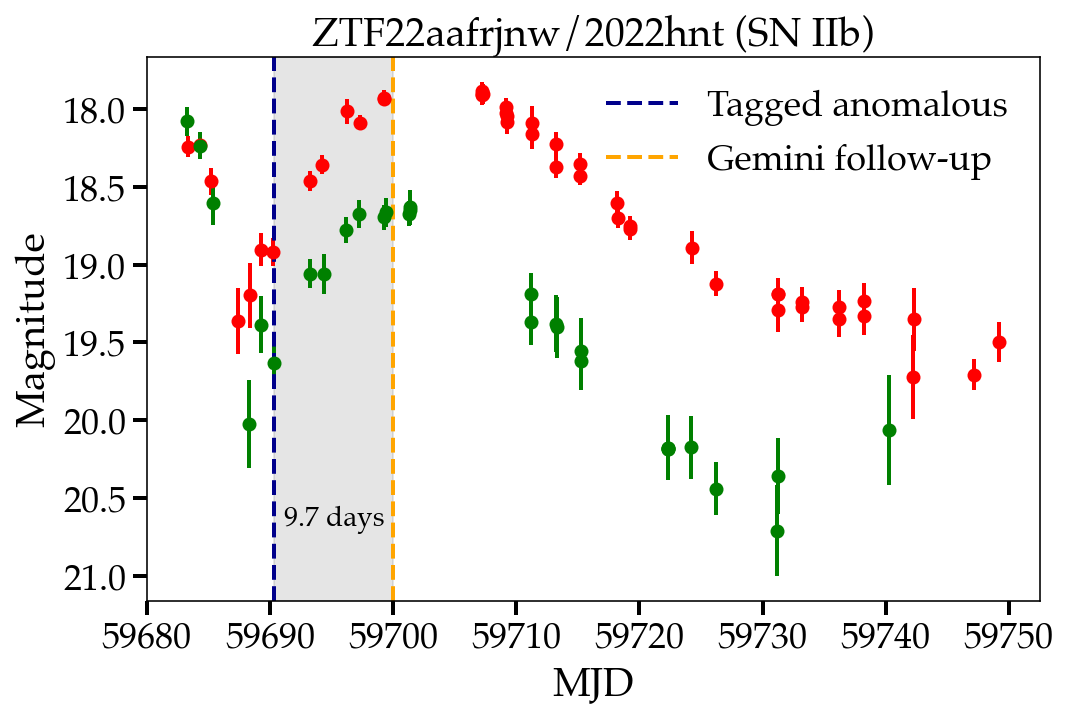

CPU times: user 940 ms, sys: 121 ms, total: 1.06 s
Wall time: 816 ms


In [203]:
%%time

fps = glob.glob("/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/*")

for fp in fps:
    ztfid = fp.split('/')[-1].split('_')[0]
    
    if ztfid == "ZTF22aafrjnw":
        try:
            print(ztfid)
            plot_RFC_prob_vs_lc_ztfid_gemini_prop(anom_ztfid=ztfid, 
                                      anom_thresh=50, 
                                      df_path=f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/",
                                      spec_tag_MJD=59700,
                                      title="ZTF22aafrjnw/2022hnt (SN IIb)",
                                      savefig=True) #may 1)
        except:
            continue

### extract features from "download photometry" tab in YSE-PZ

In [81]:
def extract_lc_and_host_features_YSE_snana_format(IAU_name, yse_lightcurve, spec_class, ra, dec, show_lc=False, show_host=False):
    IAU_name = IAU_name
    spec_class = spec_class
    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/notebooks/Gemini_proposal/timeseries"
        
    min_obs_count=4

    lightcurve = yse_lightcurve
    feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)

    g_obs = list(yse_lightcurve[yse_lightcurve.FLT == "g"].MJD)
    r_obs = list(yse_lightcurve[yse_lightcurve.FLT == "R"].MJD)
    mjd_l = sorted(g_obs+r_obs)

    lc_properties_d_l = []
    len_det_counter_r,len_det_counter_g = 0,0

    all_detections = yse_lightcurve
    for ob, mjd in enumerate(mjd_l): # requires 4 obs
        # do time evolution of detections - in chunks
        detections_pb = all_detections[all_detections["MJD"].values <= mjd]
        #print(detections)
        lc_properties_d={}
        for band, names in property_names.items():
            detections = detections_pb[detections_pb["FLT"] == band]

            # Ensure locus has >3 obs for calculation
            if (len(detections) < min_obs_count):
                continue
            #print(detections)

            t = detections['MJD'].values
            m = detections['MAG'].values
            merr = detections['MAGERR'].values
            flux = detections['FLUXCAL'].values
            fluxerr = detections['FLUXCALERR'].values

            try:
                magn_features = MAGN_EXTRACTOR(
                    t,
                    m,
                    merr,
                    fill_value=None,
                )
            except: 
                print(f"{IAU_name} is maybe not sorted?")
                return
            
            flux_features = FLUX_EXTRACTOR(
                t,
                flux,
                fluxerr,
                fill_value=None,
            )

            # After successfully calculating features, set locus properties and tag
            lc_properties_d["obs_num"] = int(ob)
            lc_properties_d["mjd_cutoff"] = mjd
            lc_properties_d["ztf_object_id"] = IAU_name
            #print(band, m)
            for name, value in zip(names, chain(magn_features, flux_features)):
                lc_properties_d[name] = value
                #if name == "feature_amplitude_magn_g": print(m, value, band)
            #print("%%%%%%%%")
        lc_properties_d_l.append(lc_properties_d)

    lc_properties_d_l = [d for d in lc_properties_d_l if d]
    lc_properties_df = pd.DataFrame(lc_properties_d_l)
    if len(lc_properties_df) == 0: 
        print(f"Not enough obs for {IAU_name}. pass!\n")
        return
    print(f"Extracted LC features for {IAU_name}!")
    
    # Get GHOST features
    ra,dec=float(ra),float(dec)
    snName=[IAU_name, IAU_name]
    snCoord = [SkyCoord(ra*u.deg, dec*u.deg, frame='icrs'), SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')]
    with tempfile.TemporaryDirectory() as tmp:
        try:
            hosts = getTransientHosts(transientName=snName, snCoord=snCoord, GLADE=True, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)
        except:
            print(f"GHOST error for {IAU_name}. Retry without GLADE. \n")
            hosts = getTransientHosts(transientName=snName, snCoord=snCoord, GLADE=False, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)       
            
    if len(hosts) > 1:
        hosts = pd.DataFrame(hosts.loc[0]).T
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = hosts_df[~hosts_df.isnull().any(axis=1)]

    if len(hosts_df) < 1:
        # if any features are nan, we can't use as input
        print(f"Some features are NaN for {IAU_name}. Skip!\n")
        return
        
    if show_host:
        print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts.raMean.values[0]}+{hosts.decMean.values[0]}&filter=color')
    
    # Define the label array
    label_arr = np.array(['ILRT', 'SLSN-I', 'SLSN-II', 'SN', 'SNII', 'SNII-pec', 'SNIIP',
       'SNIIb', 'SNIIn', 'SNIa-norm', 'SN Ia-91T-like', 'SNIa-91bg-like',
       'SNIa-CSM', 'SNIa-Ca-rich', 'SNIa-pec', 'SN Iax[02cx-like]',
       'SNIb', 'SNIb-Ca-rich', 'SNIb/c', 'SNIbc', 'SNIbn', 'SNIc', 'SNIc-BL',
       'SNIcn', 'TDE', "NA", "PHOT"])

    # Define the spectroscopic class
    spec_class = spec_class

    # Find the index of the spectroscopic class in the label array
    class_index = np.where(label_arr == spec_class)[0]

    # Create a one-hot encoded array with all zeros
    onehot_array = np.zeros(len(label_arr), dtype=float)

    # Set the corresponding index to 1
    onehot_array[class_index] = 1

    # Reshape the array to have a shape of (1, num_classes)
    onehot_array = onehot_array.reshape(1, -1)
    
    onehot_df = pd.DataFrame(np.array(onehot_array, dtype=float), columns=label_arr)
    onehot_df = pd.concat([onehot_df] * len(lc_properties_df), ignore_index=True)
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = pd.concat([hosts_df] * len(lc_properties_df), ignore_index=True)

    lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df, onehot_df], axis=1)
    lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
    lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}_timeseries.csv')
    
    print(f"Saved results for {IAU_name}!\n")

In [94]:
def plot_RFC_prob_vs_lc_yse_IAUid(anom_ztfid, anom_thresh, lc, df_path):
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        return

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    
    try:
        anom_obj_df = lc_and_hosts_df[lc_and_host_features]
    except:
        print(f"{anom_ztfid} has some NaN LC features. Skip!")
        return

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
        pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
        orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        #diff = len(orig)-len(pred_prob_anom)
        #anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]]
        anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]] #+ diff
        anom_idx_is = True
        print("Anomalous during timeseries!")

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False

    max_anom_score = max(pred_prob_anom[:, 1])
    print("max_anom_score", round(max_anom_score, 1))
    print("num_anom_epochs", num_anom_epochs)
    
    ztf_id_ref = anom_ztfid 

    df_ref_g = lc[(lc.FLT == 'g')]
    df_ref_r = lc[(lc.FLT == 'R')]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['MAG']].reset_index().idxmin().MAG
    mjd_idx_at_min_mag_g_ref = df_ref_g[['MAG']].reset_index().idxmin().MAG

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.MJD, y=df_ref_r.MAG, yerr=df_ref_r.MAGERR, fmt='o', c='r', 
                label=f'REF: {ztf_id_ref}')
    ax1.errorbar(x=df_ref_g.MJD, y=df_ref_g.MAG, yerr=df_ref_g.MAGERR, fmt='o', c='g')
    if anom_idx_is == True:
        print("MJD Cutoff anom_idx", anom_idx.mjd_cutoff)
        #print(lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx])
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx.obs_num].mjd_cutoff.values[0])
    #ax1.set_xlim(min(df_ref_r.MJD), max(df_ref_r.MJD))

    print(f'https://ziggy.ucolick.org/yse/transient_detail/{anom_ztfid}/')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
    #ax2.axhline(y=50)

    #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    plt.xlabel('mjd_cutoff')
    plt.ylabel('Probability (%)')
    plt.legend()
    plt.show()

In [82]:
from sncosmo import read_snana_ascii
SN_df = pd.read_csv("./Gemini_proposal/2023dui_data.snana.txt", comment="#", delimiter="\s+")
SN_df = SN_df[(SN_df.FLT == "r-ZTF") | (SN_df.FLT == "g-ZTF") | (SN_df.FLT == "g") | (SN_df.FLT == "r")].reset_index(drop=True)
SN_df
SN_df["FLT"] = SN_df["FLT"].map({"g-ZTF": "g", "g": "g", "r-ZTF": "R", "r": "R"})
SN_df = SN_df.sort_values('MJD')
SN_df = SN_df.dropna()
SN_df = SN_df.drop_duplicates(keep='first')
SN_df

,VARLIST:,MJD,FLT,FLUXCAL,FLUXCALERR,MAG,MAGERR,MAGSYS,TELESCOPE,INSTRUMENT,DQ
0,OBS:,59965.425,R,314.982,171.300,21.254,0.591,None,P48,ZTF-Cam,None
1,OBS:,59968.425,g,114.789,140.527,22.350,1.329,None,P48,ZTF-Cam,None
2,OBS:,59968.465,R,337.023,159.729,21.181,0.515,None,P48,ZTF-Cam,None
4,OBS:,59972.443,g,171.978,138.625,21.911,0.875,None,P48,ZTF-Cam,None
5,OBS:,59972.479,R,816.169,145.337,20.221,0.193,None,P48,ZTF-Cam,None
6,OBS:,59979.350,g,481.172,406.540,20.794,0.918,None,P48,ZTF-Cam,None
7,OBS:,59979.432,R,783.935,316.323,20.264,0.438,None,P48,ZTF-Cam,None
8,OBS:,59985.394,R,1736.267,284.965,19.401,0.178,None,P48,ZTF-Cam,None
9,OBS:,59985.436,g,814.163,274.616,20.223,0.366,None,P48,ZTF-Cam,None
10,OBS:,59992.361,R,2617.917,1251.953,18.955,0.519,None,P48,ZTF-Cam,None


In [83]:
extract_lc_and_host_features_YSE_snana_format(IAU_name="2023dui", 
                                              yse_lightcurve=SN_df, 
                                              spec_class="NA", 
                                              ra=177.8625276, 
                                              dec=19.3802447, 
                                              show_lc=False, 
                                              show_host=False)

Extracted LC features for 2023dui!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
Saved results for 2023dui!



In [92]:
ztfid_onsky_l = ["2023dui"
                ] 
#23lfn no phot, 
spec_cls_onsky_l = ["NA"
                   ]

onsky_df = pd.DataFrame(zip(ztfid_onsky_l, spec_cls_onsky_l), columns=["Disc. Internal Name", "TNS_cls"])
onsky_df = onsky_df.set_index("Disc. Internal Name")
onsky_df

,TNS_cls
Disc. Internal Name,
2023dui,NA


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for 2023dui.
max_anom_score 45.0
num_anom_epochs 0
https://ziggy.ucolick.org/yse/transient_detail/2023dui/


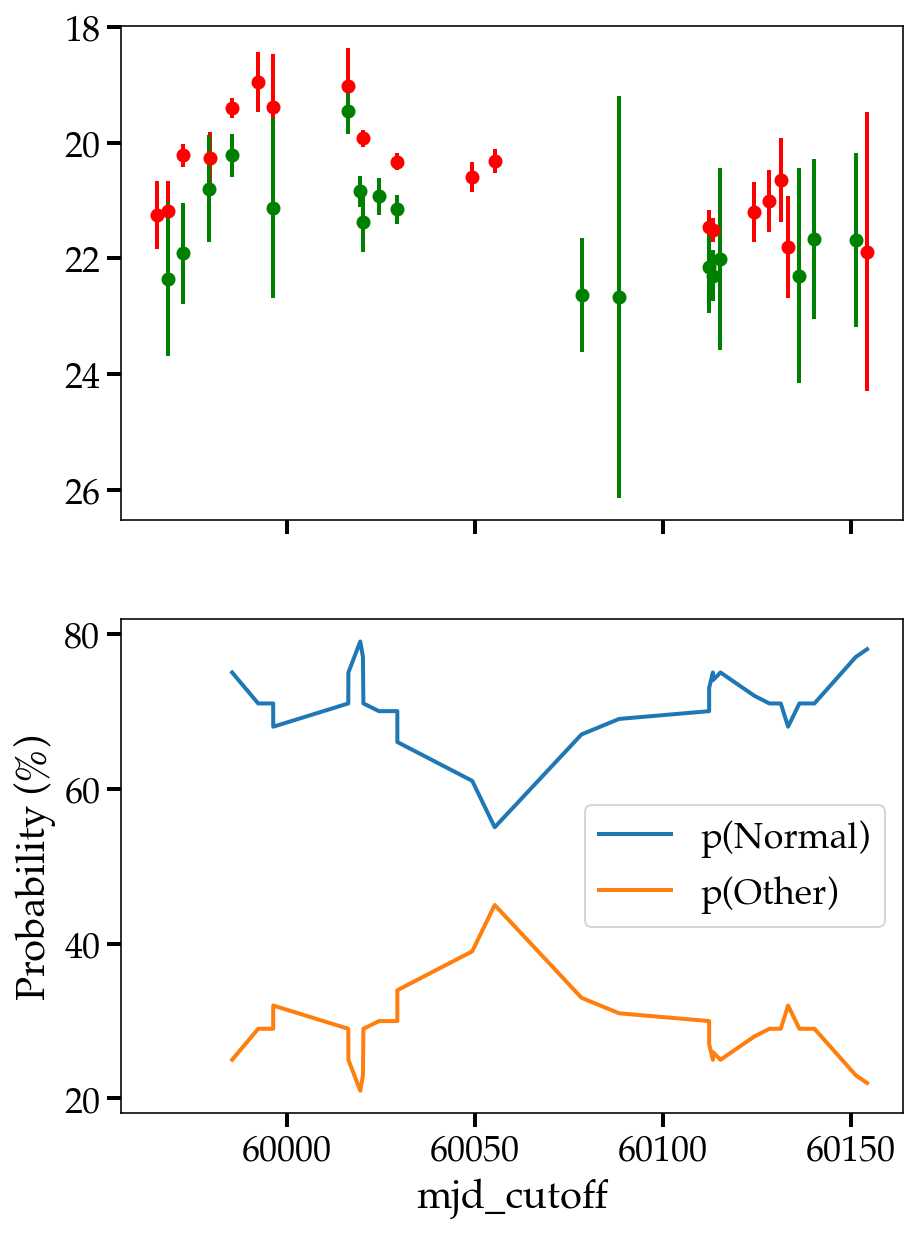

CPU times: user 263 ms, sys: 21.4 ms, total: 285 ms
Wall time: 287 ms


In [95]:
%%time

fps = glob.glob("/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/notebooks/Gemini_proposal/timeseries/*")

for fp in fps:
    ztfid = fp.split('/')[-1].split('_')[0]
    
    for obj in onsky_df.index:
        if ztfid == obj:
            try:
                plot_RFC_prob_vs_lc_yse_IAUid(anom_ztfid=ztfid, 
                                          anom_thresh=50, 
                                          lc=SN_df,
                                          df_path=f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/notebooks/Gemini_proposal/timeseries/",)
            except:
                continue

In [14]:
# Check which iso_forest_AD_objects are in train/test
bank_and_tns_df = pd.read_csv('../loci_dbs/alerce_cut/bank_and_tns_df.csv.gz', compression='gzip', index_col=0)
bank_and_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,1.501946,0.581482,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,-0.323815,0.000616,...,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232,Yes_TNS,None,-99.00,GaiaAlerts
ZTF17aadqidc,0.118791,0.276625,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,-0.817505,0.013288,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.00,None
ZTF17aaducdh,0.384243,0.400104,0.333333,0.083333,0.379044,0.768486,0.586268,0.218094,0.425088,0.025251,...,0.223600,0.021301,0.269098,0.174500,11.297927,0.018901,Yes_TNS,None,-99.00,GaiaAlerts
ZTF18aaaokus,1.337077,4.369050,0.320225,0.005618,0.365946,2.108598,1.640040,0.837900,-0.695091,-0.001890,...,1.217501,1.251801,1.243600,1.272200,119.727409,0.005603,Yes_TNS,None,-99.00,ZTF
ZTF18aaavffc,1.251362,2.169584,0.291667,0.025000,0.338697,2.387948,2.022931,0.747013,-0.276298,-0.002842,...,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534,Yes_TNS,None,-99.00,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,0.068989,0.268161,0.500000,0.000000,0.381361,0.137978,0.132096,0.079157,-0.901772,-0.028012,...,0.708401,0.683500,0.644199,0.548500,25.406284,1.134230,Yes_TNS,SN Ia,0.09,ZTF
ZTF22aaboiqa,0.205293,0.126299,0.400000,0.000000,0.364903,0.410585,0.410585,0.253444,-1.169788,-0.029534,...,-0.035500,-0.026699,0.067301,-0.125101,10.365118,0.148034,Yes_TNS,None,-99.00,ANTARES
ZTF22aabovlw,0.113249,0.078036,0.500000,0.000000,0.396465,0.226498,0.226498,0.157836,-1.919301,0.000368,...,0.606100,0.483999,0.585100,0.647001,33.811442,4.407910,Yes_TNS,None,-99.00,ANTARES


In [15]:
to_check_l = ["ZTF21abgkfzh", "ZTF22aadesjc", "ZTF22abfdzrv", "ZTF22abghrui", "ZTF22abhwlnm",
              "ZTF18aaiwzie", "ZTF23aadbtou", "ZTF23aadjssg", "ZTF23aaekebt", "ZTF23aaweqva",
              "ZTF21abiggqx", "ZTF22aatwxrl", "ZTF22abrbohu", "ZTF22absuavp", "ZTF22abzajwl",
              "ZTF23aaahnss", "ZTF23aaempzk", "ZTF23aaefpfb", "ZTF23aafgmaz", "ZTF23aaflptz",
              "ZTF23aagxvad", "ZTF23aahjdxa", "ZTF23aaiwzec", "ZTF23aaizezh", "ZTF23aajestr",
              "ZTF23aarzzwu", "ZTF23aatcola", "ZTF23aatcsou", "ZTF23aawehtg"
             ]



In [16]:
out = bank_and_tns_df.index.isin(to_check_l)
bank_and_tns_df[out]

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abgkfzh,0.441565,0.789434,0.294118,0.088235,0.396573,0.869656,0.599177,0.282619,0.081786,0.004576,...,0.5291,0.456400,0.356501,0.303902,3.713982,0.682704,Yes_TNS,SN IIn,0.086,ATLAS
ZTF21abiggqx,0.571587,2.821801,0.314286,0.042857,0.389642,1.052066,0.826748,0.439058,-0.208532,0.003489,...,1.1126,1.276899,0.391600,0.333099,17.474474,0.051271,Yes_TNS,None,-99.000,ALeRCE
